In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
import itertools # to connect a list of lists to one

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
link = "https://raw.githubusercontent.com/RuiVelho/My-movie-review-prediction/main/rotten_tomatoes_movies.csv"
df_k1 = pd.read_csv(link)
df_k1.head(2)

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19


In [ ]:
df_k1.movie_info[0]

"Always trouble-prone, the life of teenager Percy Jackson (Logan Lerman) gets a lot more complicated when he learns he's the son of the Greek god Poseidon. At a training ground for the children of deities, Percy learns to harness his divine powers and prepare for the adventure of a lifetime: he must prevent a feud among the Olympians from erupting into a devastating war on Earth, and rescue his mother from the clutches of Hades, god of the underworld."

In [ ]:
df_k1.critics_consensus[0]

'Though it may seem like just another Harry Potter knockoff, Percy Jackson benefits from a strong supporting cast, a speedy plot, and plenty of fun with Greek mythology.'

In [ ]:
df_k1.isna().sum()

rotten_tomatoes_link                   0
movie_title                            0
movie_info                           321
critics_consensus                   8578
content_rating                         0
genres                                19
directors                            194
authors                             1542
actors                               352
original_release_date               1166
streaming_release_date               384
runtime                              314
production_company                   499
tomatometer_status                    44
tomatometer_rating                    44
tomatometer_count                     44
audience_status                      448
audience_rating                      296
audience_count                       297
tomatometer_top_critics_count          0
tomatometer_fresh_critics_count        0
tomatometer_rotten_critics_count       0
dtype: int64

If the positive reviews make up 60% or more, the film is considered "fresh". If the positive reviews are less than 60%, the film is considered "rotten".

In [ ]:
df_k1.tomatometer_status.value_counts()

Rotten             7565
Fresh              6844
Certified-Fresh    3259
Name: tomatometer_status, dtype: int64

### Analyze 'critics_consensus' 

In [ ]:
df_k1 = df_k1[df_k1['critics_consensus'].notna()]
df_k1 = df_k1[df_k1['tomatometer_status'].notna()]

In [ ]:
df = df_k1[['critics_consensus', 'tomatometer_status']]

In [ ]:
df.head(5)

,critics_consensus,tomatometer_status
0,Though it may seem like just another Harry Pot...,Rotten
1,Nicole Holofcener's newest might seem slight i...,Certified-Fresh
2,Blake Edwards' bawdy comedy may not score a pe...,Fresh
3,Sidney Lumet's feature debut is a superbly wri...,Certified-Fresh
4,"One of Disney's finest live-action adventures,...",Fresh


In [ ]:
def clean_description_column(df, column_name):

  stop_words = set(nltk.corpus.stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()

  def is_word(word):
    
    synsets = wordnet.synsets(word)
    return len(synsets) > 0

  def clean_text(text):
    
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words and token not in punctuation]
    tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]
    tokens = [token for token in tokens if is_word(token)]
    return ' '.join(tokens)
    #return tokens

  cleaned_column = df[column_name].apply(clean_text)
  #return cleaned_column

  # the 10 most common words
  all_words = ' '.join(cleaned_column).split()
  word_counts = Counter(all_words)
  top_10_words = dict(word_counts.most_common(10))
  print('Top 10 most used words:')
  for word, count in top_10_words.items():
    print(f'{word}: {count}')

  # Word Cloud
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
  plt.figure(figsize=(12, 8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

  return cleaned_column

In [ ]:
def perform_sentiment_analysis(cleaned_column):
  sid = SentimentIntensityAnalyzer()
  sentiment_scores = cleaned_column.apply(lambda x: sid.polarity_scores(x))
  sentiment_df = pd.concat([cleaned_column, sentiment_scores.apply(pd.Series)], axis=1)
  return sentiment_df

#### NLP & Sentiment Analysis for 'Rotten' 

In [ ]:
df_rotten = df[df.tomatometer_status == 'Rotten']

Top 10 most used words:
story: 363
cast: 339
movie: 327
plot: 310
enough: 295
make: 293
lack: 271
character: 252
film: 251
comedy: 233


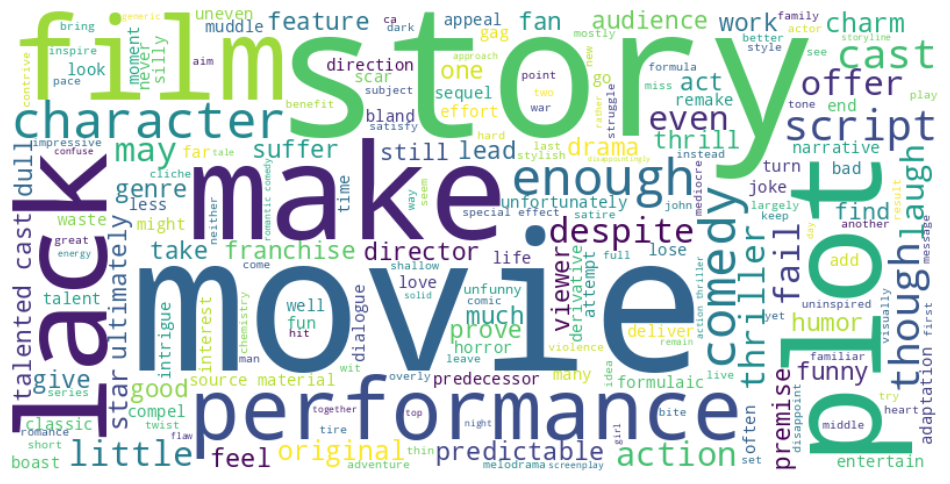

0        though may seem like another harry potter knoc...
5        attention strictly pay style instead substance...
12       heart right place start promise exercise devol...
15       despite cast impressive bridge lifeless adapta...
25       competent somewhat static tristan isolde achie...
                               ...                        
17696    zombi 2 absurdly graphic zombie movie legendar...
17698    though intentionally campy zombie strippers su...
17703    smother jam sodden script surfeit joke inappro...
17705    2 celebrity cameos laugh meager handful memora...
17706      lack punch good cheer sky high zoom dull affair
Name: critics_consensus, Length: 3669, dtype: object

In [ ]:
cleaned_column = clean_description_column(df_rotten, 'critics_consensus')
cleaned_column

In [ ]:
sentiment_df = perform_sentiment_analysis(cleaned_column)
sentiment_df

,critics_consensus,neg,neu,pos,compound
0,though may seem like another harry potter knoc...,0.000,0.503,0.497,0.9300
5,attention strictly pay style instead substance...,0.095,0.680,0.224,0.4404
12,heart right place start promise exercise devol...,0.243,0.588,0.169,-0.2500
15,despite cast impressive bridge lifeless adapta...,0.208,0.615,0.177,-0.1032
25,competent somewhat static tristan isolde achie...,0.000,0.560,0.440,0.6705
...,...,...,...,...,...
17696,zombi 2 absurdly graphic zombie movie legendar...,0.000,1.000,0.000,0.0000
17698,though intentionally campy zombie strippers su...,0.460,0.540,0.000,-0.7700
17703,smother jam sodden script surfeit joke inappro...,0.187,0.667,0.147,-0.1531
17705,2 celebrity cameos laugh meager handful memora...,0.124,0.567,0.309,0.5574


#### NLP & Sentiment Analysis for 'Fresh'

Top 10 most used words:
make: 222
story: 214
performance: 202
performances: 195
cast: 167
may: 166
film: 162
offer: 150
enough: 147
comedy: 118


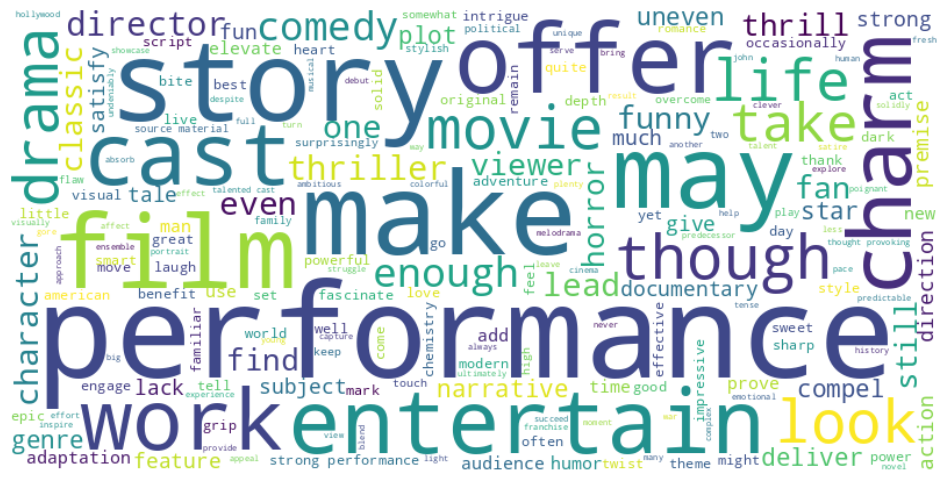

2        blake edwards bawdy comedy may score perfect 1...
4        one disney finest adventure league sea bring v...
14       match witty sophisticate screenplay george spe...
17       saw nine queen may feel redundant snappy perfo...
19       full visually strike footage deep blue may int...
                               ...                        
17695    obviously high art deliver enough gory insanit...
17697    auspicious feature debut director lee zombie s...
17700    double tap make lack fresh brain enjoyable reu...
17704    wacky satire fashion industry one deliberately...
17710    zulu patiently establish cast colorful charact...
Name: critics_consensus, Length: 2268, dtype: object

In [ ]:
df_fresh = df[df.tomatometer_status == 'Fresh']
cleaned_column = clean_description_column(df_fresh, 'critics_consensus')
cleaned_column

In [ ]:
sentiment_df = perform_sentiment_analysis(cleaned_column)
sentiment_df

,critics_consensus,neg,neu,pos,compound
2,blake edwards bawdy comedy may score perfect 1...,0.169,0.455,0.376,0.6124
4,one disney finest adventure league sea bring v...,0.000,0.686,0.314,0.7506
14,match witty sophisticate screenplay george spe...,0.000,0.736,0.264,0.5106
17,saw nine queen may feel redundant snappy perfo...,0.000,0.752,0.248,0.5106
19,full visually strike footage deep blue may int...,0.074,0.591,0.335,0.6486
...,...,...,...,...,...
17695,obviously high art deliver enough gory insanit...,0.202,0.546,0.251,-0.0258
17697,auspicious feature debut director lee zombie s...,0.000,0.872,0.128,0.2960
17700,double tap make lack fresh brain enjoyable reu...,0.101,0.351,0.548,0.8481
17704,wacky satire fashion industry one deliberately...,0.187,0.455,0.358,0.4588


## Analyze 'movie_info'

In [ ]:
df1 = df_k1[['movie_info', 'tomatometer_status']]
df1 = df1[df1['movie_info'].notna()]
df1 = df1[df1['tomatometer_status'].notna()]

Top 10 most used words:
find: 821
life: 657
new: 649
one: 559
become: 545
take: 528
must: 502
get: 492
young: 489
live: 461


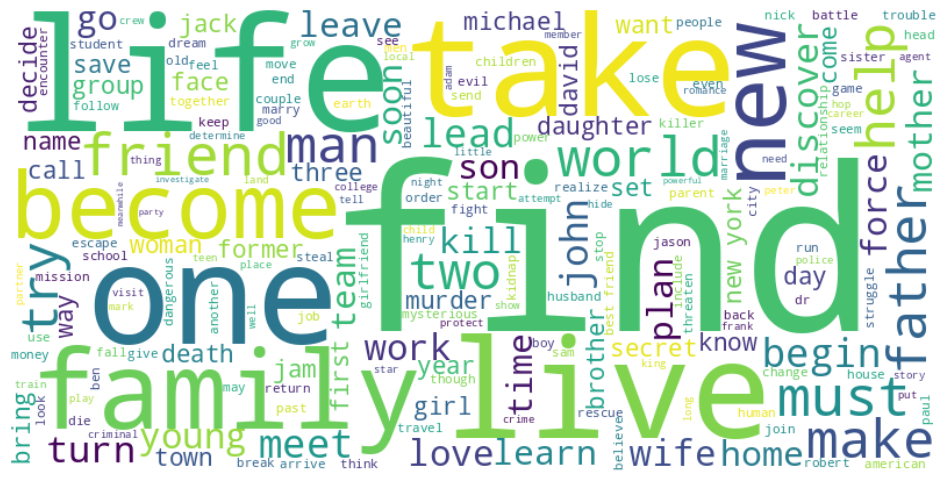

0        always life teenager percy jackson logan get l...
5        mammoth hunter strait long love beautiful blue...
12       apolitical havana club owner get catch middle ...
15       spanish inquisition franciscan monk brother ju...
25       fall roman empire english orphan tristan meet ...
                               ...                        
17696    new york reporter follow woman farrow island d...
17698    many war soldier lab develop virus bring dead ...
17703    kindhearted griffin key jam one best-loved car...
17705    former model ben stiller find thrust back spot...
17706    zoom jack allen know long give career fight ev...
Name: movie_info, Length: 3646, dtype: object

In [ ]:
df1_rotten = df1[df1.tomatometer_status == 'Rotten']
cleaned_column = clean_description_column(df1_rotten, 'movie_info')
cleaned_column

Top 10 most used words:
find: 419
life: 376
new: 351
become: 308
take: 307
young: 303
live: 279
one: 278
family: 265
get: 256


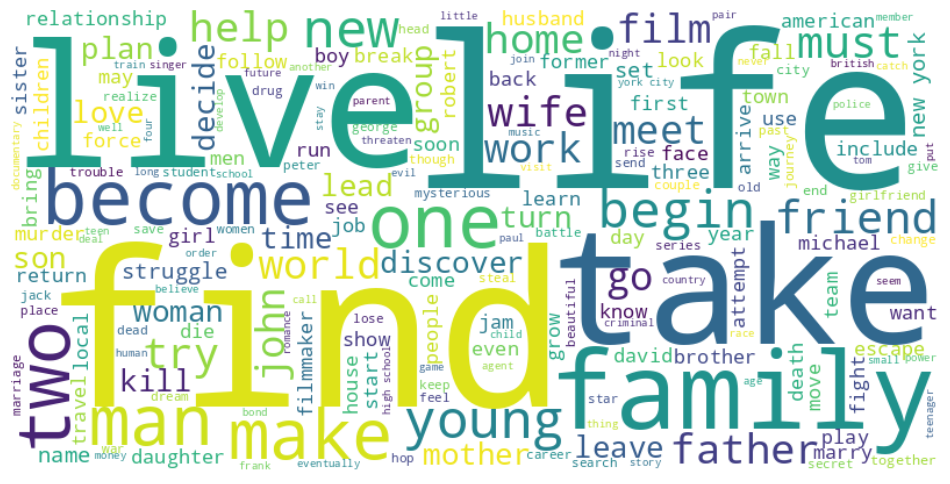

2        successful middle-aged hollywood songwriter fa...
4        professor pierre paul assistant peter lorre st...
14       courtroom rivalry find way household prosecute...
17       need new partner capable intricate con gaddis ...
19       nature documentary show live different animals...
                               ...                        
17686    private investigator zero bill pullman one fin...
17695    college friends find weekend sex debauchery ru...
17700    zombie slayers tallahassee columbus wichita li...
17704    propel top fashion world photogenic gaze call ...
17710    zulu nation hand colonial british force resoun...
Name: movie_info, Length: 2230, dtype: object

In [ ]:
df1_fresh = df1[df1.tomatometer_status == 'Fresh']
cleaned_column = clean_description_column(df1_fresh, 'movie_info')
cleaned_column

## Analyze 'movie_title'

In [ ]:
df2 = df_k1[['movie_title', 'tomatometer_status']]
df2 = df2[df2['movie_title'].notna()]
df2 = df2[df2['tomatometer_status'].notna()]

Top 10 most used words:
2: 94
love: 55
man: 54
movie: 44
last: 38
night: 29
ii: 29
house: 28
life: 25
dead: 25


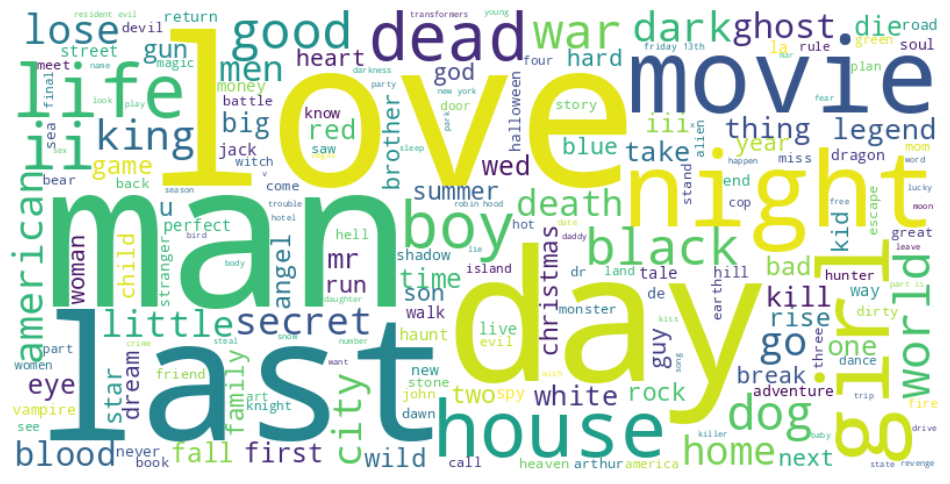

0        percy jackson olympians lightning thief
5                                               
12                                     lose city
15                                        bridge
25                                tristan isolde
                          ...                   
17696                             zombie zombi 2
17698                           zombie strippers
17703                                           
17705                                          2
17706                                       zoom
Name: movie_title, Length: 3669, dtype: object

In [ ]:
df2_rotten = df2[df2.tomatometer_status == 'Rotten']
cleaned_column = clean_description_column(df2_rotten, 'movie_title')
cleaned_column

Top 10 most used words:
man: 41
life: 31
2: 27
night: 20
love: 20
last: 19
time: 18
world: 18
day: 17
dead: 17


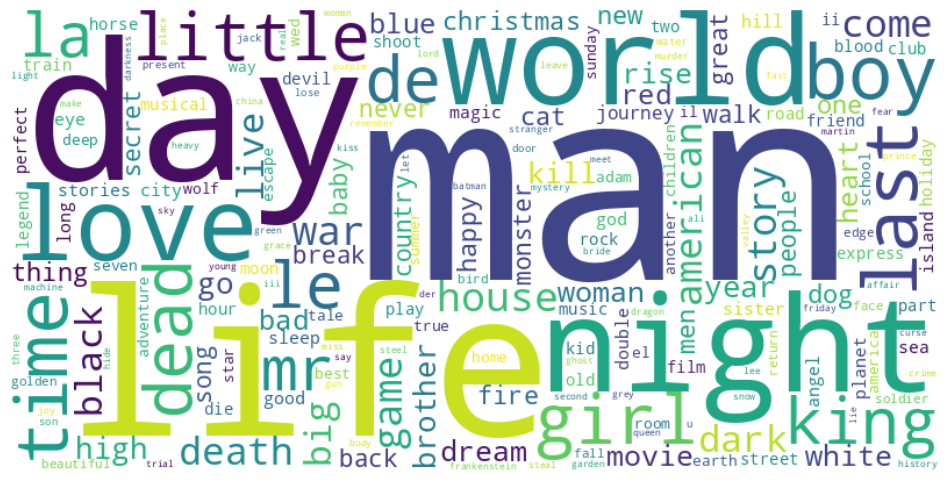

2                 10
4         league sea
14          adam rib
17          criminal
19         deep blue
            ...     
17695               
17697    zombie sale
17700     double tap
17704               
17710           zulu
Name: movie_title, Length: 2268, dtype: object

In [ ]:
df2_fresh = df2[df2.tomatometer_status == 'Fresh']
cleaned_column = clean_description_column(df2_fresh, 'movie_title')
cleaned_column